# Introduction to 3S-GEOPROF-COMB
Globally-gridded (3S) GEOmetrical PROFiles of hydrometeors COMBined radar-lidar dataset. This notebook is a brief introduction to the product and gives some plotting examples. 

Let's load in a granule:

In [1]:
import os

import matplotlib.pyplot as plt   # for plotting
import numpy as np                # for arrays+math
import xarray as xr               # for netCDF data

import cartopy.crs as ccrs        # import projections
import cartopy.feature as cf      # import features

In [2]:
# replace this with any data product granule of interest
ds=xr.open_dataset("./data/2007-DJF_CSCAL_3S-GEOPROF-COMB_10.0x10.0_v8.4.nc")
ds

<xarray.Dataset>
Dimensions:                                 (doop: 2, lat: 18, lon: 36,
                                             height: 78, type: 8, localhour: 4,
                                             bound: 2)
Coordinates:
    time                                    datetime64[ns] ...
  * height                                  (height) float64 -480.0 ... 1.799...
  * lat                                     (lat) float64 -85.0 -75.0 ... 85.0
  * lon                                     (lon) float64 -175.0 ... 175.0
  * doop                                    (doop) |S16 b'DO-OP observable' b...
  * type                                    (type) |S12 b'any' ... b'uniquelow'
  * localhour                               (localhour) |S5 b'01:00' ... b'19...
Dimensions without coordinates: bound
Data variables: (12/14)
    cloud_counts_on_levels                  (doop, lat, lon, height) int64 ...
    total_counts_on_levels                  (doop, lat, lon, height) int64 ...
    cloud_counts_in_column                  (type, doop, lat, lon) int64 ...
    total_counts_in_column                  (type, doop, lat, lon) int64 ...
    attenuated_lidar_counts_on_levels       (doop, lat, lon, height) int64 ...
    attenuated_lidar_counts_in_column       (doop, lat, lon) int64 ...
    ...                                      ...
    n_days                                  (doop, lat, lon) int64 ...
    localhour_counts                        (localhour, doop, lat, lon) int64 ...
    height_bounds                           (height, bound) float64 ...
    cloud_fraction_on_levels                (doop, lat, lon, height) float64 ...
    cloud_cover_in_column                   (type, doop, lat, lon) float64 ...
    localhour_bounds                        (localhour, bound) |S5 ...
Attributes:
    date_created:      2024-07-16 18:39:47 MST
    citation:          Please cite Bertrand, L., Kay, J. E., Haynes, J., and ...
    from_script:       file created by script build_seasonal_from_monthly_v8....
    from_command:      ./build_seasonal_from_monthly_v8.4.py monthsall_v8.4-g...
    num_granules:      1131
    keep_type:         calculated only from granules for which both radar and...
    resolution_lon:    10.0
    resolution_lat:    10.0
    time_range:        2007-12-01 00:00:00 UTC - 2008-02-29 23:59:05 UTC
    Conventions:       CF-1.8
    max_num_granules:  1310
    instrument_type:   calculated from merged CloudSat and CALIPSO hydrometeo...

Hydrometeor variables fall into two types:
1. cloud cover variables showing how many profiles satisfy certain criteria (any clouds, high clouds, etc.) -- these end with `_in_column`, and
2. vertical cloud fraction variables showing how frequently a vertical level matches a certain description (cloudy, clear, cluttered, etc.) -- these end with `_on_levels`.

For both of these categories, the product reports the number of observations with clouds (`cloud_counts_...`), the total number of observations (`total_counts_...`), and the frequency of occurrence (`cloud_cover_...` or `cloud_fraction...`). __The frequency is simply the ratio of the cloud counts to the total counts.__

# Cloud and total counts vs. cloud cover
Let's check this with total cloud cover (how frequently any cloud is present in the profile):

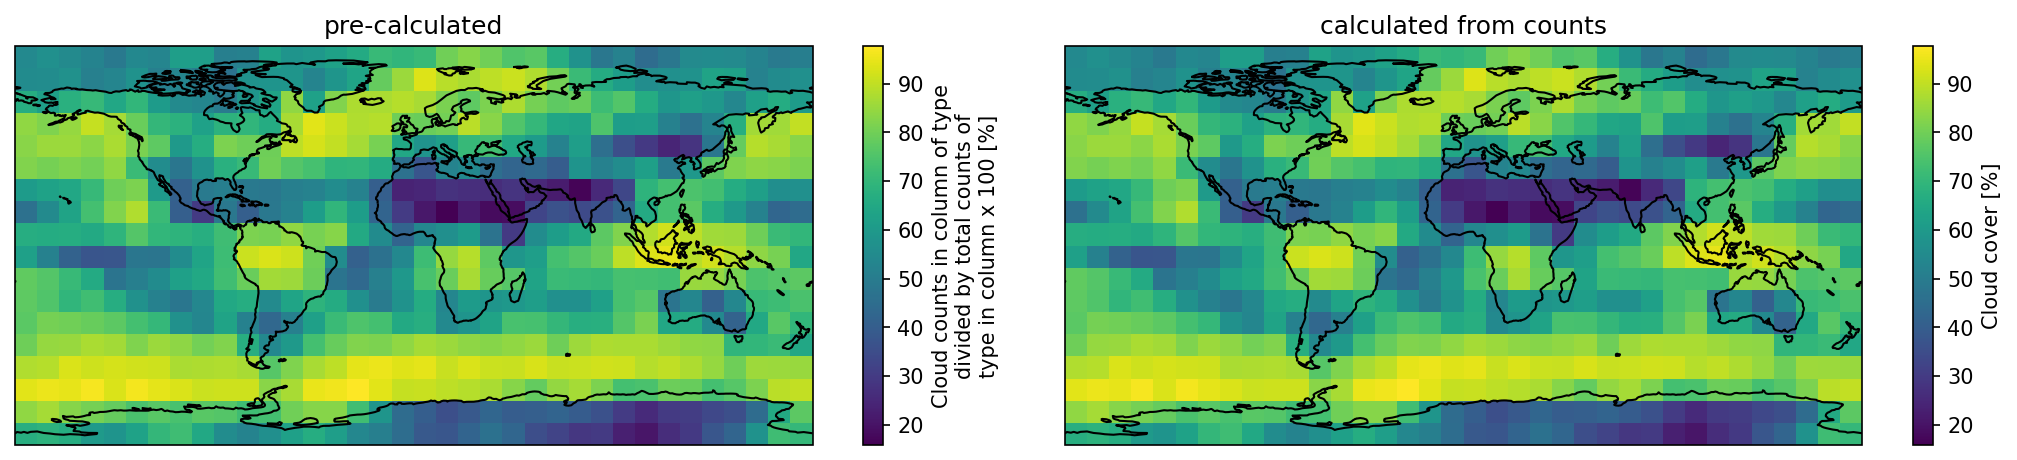

In [3]:
cloud_type=b'any' #options are in ds.type
doop_mode=b'All cases' #sampling mode, explained later

plt.figure(figsize=(14,3),dpi=150)

#pre-calculated cloud cover
plt.subplot(121,projection=ccrs.PlateCarree()) 
ds.cloud_cover_in_column.sel(doop=doop_mode).sel(type=cloud_type).plot() #select a sampling mode and cloud type
plt.gca().coastlines()
plt.title('pre-calculated')

#cloud cover calculated from counts
plt.subplot(122,projection=ccrs.PlateCarree())
cloud_cover = 100*ds.cloud_counts_in_column/ds.total_counts_in_column #cloud cover = cloud counts / total counts
cloud_cover.sel(doop=doop_mode).sel(type=cloud_type).plot(cbar_kwargs={'label':'Cloud cover [%]'}) #same as above
plt.gca().coastlines()
plt.title('calculated from counts')

plt.tight_layout()

And the results are the same. This is useful if you want to redefine cloud frequency, re-grid the data, or aggregate in some way -- if the process is applied separately to `cloud_counts` and `total_counts` rather than frequency, then we won't accidentally be applying any weighting to our data.

# Daylight-only operations (DO-OP) mode

In the previous example, we also needed to select a coordinate on the `doop` dimension. This selects our sampling mode. There are two options:

In [4]:
ds.doop

<xarray.DataArray 'doop' (doop: 2)>
array([b'DO-OP observable', b'All cases'], dtype='|S16')
Coordinates:
    time     datetime64[ns] ...
  * doop     (doop) |S16 b'DO-OP observable' b'All cases'
Attributes:
    long_name:  Daylight-only operations status

This allows the choice to apply Daylight-Only Operations (DO-OP) mode subsampling (`b'DO-OP observable'`), which is when CloudSat transitioned to only operating in the sunlit portion of its orbit in November 2011. If we don't want to apply any subsampling, we can select `b'All cases'`.

For the pre-DO-OP data (June 2006 to April 2011), the `b'DO-OP Observable'` field gives the total observations subsampled to only what would have been observed in DO-OP mode. This way users can applying a consistent sampling methodology to the entire dataset or see how the DO-OP subsampling affects their analysis by comparing to all observations. 

After April 2011, `b'DO-OP observable'` and `b'All cases'` are the same, since all data is collected in DO-OP mode.

Here's an example of how DO-OP mode might affect zonal-mean vertical cloud fraction:

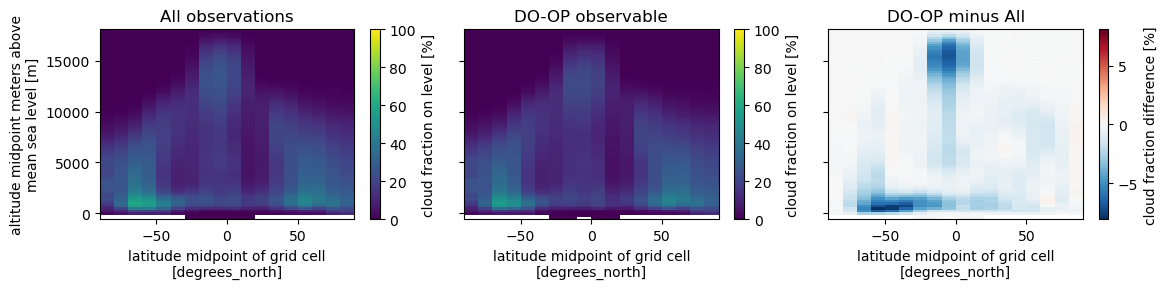

In [5]:
#get data to plot
zonal_mean = ds.cloud_fraction_on_levels.mean(dim='lon').T #take the zonal-mean
da_all     = zonal_mean.sel(doop=b'All cases') #keep all data
da_doop    = zonal_mean.sel(doop=b'DO-OP observable') #subsample data

#make figure
fig,axes = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True,dpi=100)

#all observations
plt.subplot(131) 
da_all.plot(ax=axes[0],cbar_kwargs={'label':'cloud fraction on level [%]'},vmin=0,vmax=100)
plt.title('All observations')


#DO-OP subsampled data
plt.subplot(132)
da_doop.plot(ax=axes[1],cbar_kwargs={'label':'cloud fraction on level [%]'},vmin=0,vmax=100)
plt.title('DO-OP observable')
plt.ylabel('')

#effect of DO-OP
plt.subplot(133)
(da_doop-da_all).plot(ax=axes[2],cbar_kwargs={'label':'cloud fraction difference [%]'},cmap='RdBu_r') #same as above
plt.title('DO-OP minus All')
plt.ylabel('')

plt.tight_layout()

This type of analysis is important to get a rough idea of how the data excluded by DO-OP mode might affect your results.

# Sampling variables

The data product also includes a number of sampling variables -- the most important of which is the number of unique overpasses of a grid cell (`n_overpasses`), but also the number of days observed and the approximate local time of observations. 

Let's check how DO-OP mode affects the local time at which data is collected:

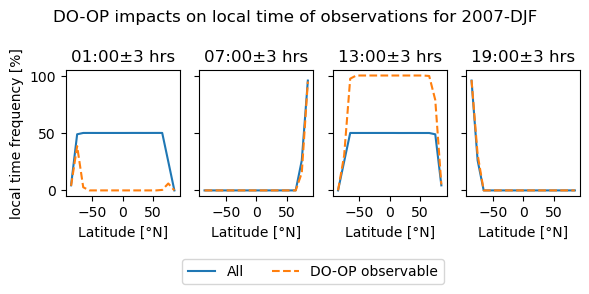

In [6]:
#when the granule is from
time_label = os.path.split(ds.encoding['source'])[-1][:8]

#total number of profiles
total_counts = ds.total_counts_in_column.sel(type=b'any')

#zonal-mean frequency of local time bin
f_hr = (ds.localhour_counts/total_counts).mean('lon')

#plot
fig,axes = plt.subplots(1,4,sharex=True,figsize=(6,2.5),sharey=True)
for ax,lt in zip(axes,ds.localhour):
    da = f_hr.sel(localhour=lt)
    ax.plot(da.lat,100*da.sel(doop=b'All cases'),ls='-',label='All')
    ax.plot(da.lat,100*da.sel(doop=b'DO-OP observable'),ls='--',label='DO-OP observable')
    ax.set_xlabel('Latitude [°N]')
    ax.set_title(f"{lt.data.item(0).decode('utf-8')}±3 hrs")
axes[0].set_ylabel('local time frequency [%]')
fig.suptitle(f'DO-OP impacts on local time of observations for {time_label}')
fig.tight_layout()
axes[1].legend(ncol=2,bbox_to_anchor=[1,-0.75],loc='lower center')

Aside from the polar latitudes, the observations are either at 01:30 (descending branch of the orbit) or 13:30 (ascending branch of the orbit) local time. For some months, DO-OP mode preserves the night-time data for some northern hemisphere latitudes, but for this period the midlatitudes and Arctic are almost exclusively daytime data.